## Generate synthetic Anomalies

trying to replicate the synthethic anomalies from the LOE paper

https://arxiv.org/abs/2202.08088
"""
Since the MVTEC training set contains
no anomalies, we contaminate it with artificial anomalies
that we create by adding zero-mean Gaussian noise to the
features of test set anomalies. We use a large variance for
the additive noise (equal to the empirical variance of the
anomalous features) to reduce information leakage from the
test set into the training set.
"""


$$X = \text{Wideresnet or other embeddings},A = \text{Real Anomalies}, S = \text{Synthethic Anomalies}$$
Assumed A is multivariate Gauss (which they are most probably not):
$$\mathbf{A} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}_{A})$$
They assume noise $\mathbf{\epsilon}$ to be added to the anomalies of the testset which increases the variance of S:
$$\mathbf{\epsilon} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma_{A}})$$
Therefore:
$$\mathbf{S} \sim \mathcal{N}(\boldsymbol{\mu},  \boldsymbol{\Sigma_{A}} + \boldsymbol{\Sigma_{A}})$$

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.image as mpimg

import pandas as pd
import numpy as np

import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import seaborn as sns

# FILEPATH: /home/bule/projects/MVTec_Visualizer/workspace/mvtec_syntheticAnomalies.ipynb
import sys
sys.path.append('..')
from utils.helpers import *
# PATHs
PROJECT_DATA_PATH='//home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection'
LOG_DIR= '/home/bule/projects/MVTec_Visualizer/tensorboard_logs'

In [2]:
# select the embeddings & read it 
FILENAME =  'MVTEC_WIDERESNET50_3thBlock_embeddings_df'#'MVTEC_CLIP_embeddings_df'#'MVTEC_WIDERESNET50_3thBlock_embeddings_df'
df = pd.read_pickle(os.path.join(PROJECT_DATA_PATH,FILENAME+'.pkl'))
image_paths=[pts[1:]for pts in df.index]
df = df.set_index(pd.Index(image_paths))

In [3]:
# if wideresnet features select do not plot , too large
if "WIDERESNET50" not in FILENAME:
    # Generate 512 random features
    data = torch.randn(1000, 512)

    # Calculate the correlation matrix
    correlation_matrix = torch.corrcoef(data.t())  # Transpose to row-wise features
    correlation_matrix_numpy = correlation_matrix.numpy()

    # Generate 512 clip features
    data_clip = torch.Tensor(df.to_numpy())

    # Calculate the correlation matrix
    correlation_matrix_clip = torch.corrcoef(data_clip.t())  # Transpose to row-wise features
    correlation_matrix_clip_numpy = correlation_matrix_clip.numpy()

    # Concatenate the two correlation matrices side by side
    combined_correlation_matrix = np.concatenate((correlation_matrix_numpy,
                                                    correlation_matrix_clip_numpy), axis=1)

    # Plot the combined correlation matrix
    plt.figure(figsize=(20, 10))
    plt.imshow(combined_correlation_matrix, plt.cm.RdBu, vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Random and Clip Features")
    plt.show()

In [75]:
anomaly_categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'cable': ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation'],
    'capsule': ['crack', 'faulty_imprint', 'poke', 'scratch','squeeze'],
    'carpet': ['color', 'cut', 'hole', 'metal_contamination', 'thread'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination', 'thread'],
    'hazelnut': ['crack', 'cut', 'hole', 'print'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke'],
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'pill': ['color', 'combined','contamination', 'crack', 'faulty_imprint', 'pill_type','scratch'],
    'screw': ['manipulated_front', 'scratch_head', 'scratch_neck','thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil','rough'],
    'toothbrush': ['defective'],
    'transistor': ['bent_lead', 'cut_lead', 'damaged_case', 'misplaced'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'zipper': ['broken_teeth', 'combined','fabric_border', 'fabric_interior','split_teeth','rough', 'squeezed_teeth']}


# change class here
category='metal_nut'
#number of synthetic anomalies to create
n_synthetic=30

synthetic_sampling_method='additive_0_mean_gauss' #  or multivariate_gauss
#synthetic_sampling_method='multivariate_gauss' #  or multivariate_gauss

# create synthetic anomalies
combined_samples,labels,class_list= create_synset_for_class(category,df,n_synthetic, sampler=synthetic_sampling_method,anomaly_categories=anomaly_categories)

info={'filename':FILENAME,'category':category,'n_synthetic':n_synthetic,'sampler':synthetic_sampling_method}

### show featuremaps from Widresnet features

show only the first feature map , real and synthetic , works only for resnetfeatures or conv features.

<Axes: >

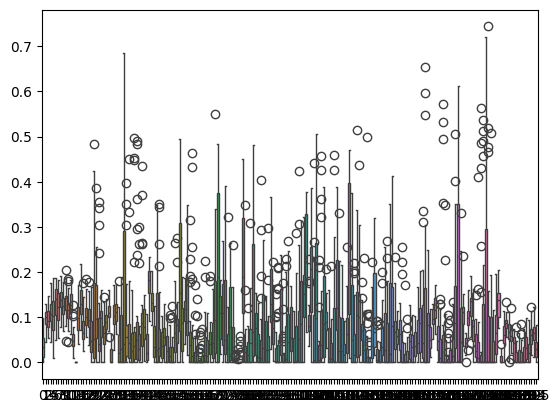

In [88]:
## Features are not normal distributed , so if you add -1 to pixel 0 it will be negative!!

sns.boxplot(combined_samples[list(np.where(labels == (class_list.index(anomaly_type)))[0]), :14*14])


<Axes: >

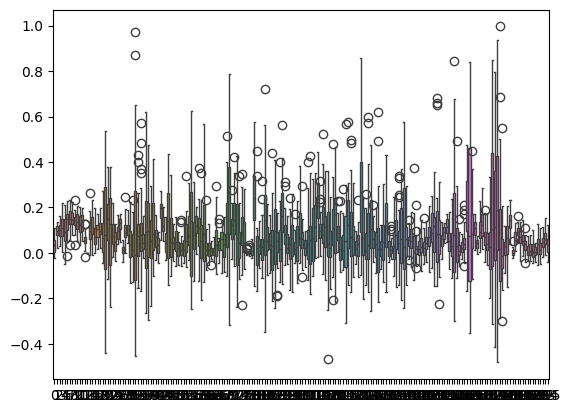

In [87]:
sns.boxplot(combined_samples[list(np.where(labels == (class_list.index(anomaly_type)+1))[0]), :14*14])

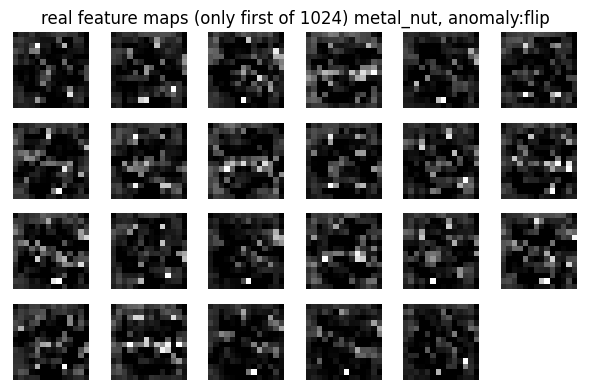

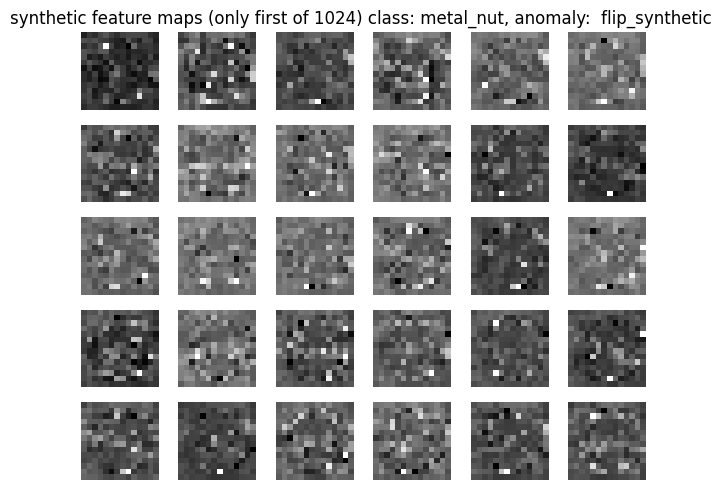

In [84]:
if "WIDERESNET50" in FILENAME:
    # select anomaly type
    anomaly_type = 'flip'

    ################### real
    real_images = combined_samples[list(np.where(labels == (class_list.index(anomaly_type)))[0]), :14*14]
    real_images= real_images.reshape(real_images.shape[0],14,14)
    real_images = (real_images - real_images.min()) / (real_images.max() - real_images.min())



    num_rows = int(np.sqrt(real_images.shape[0]))
    num_cols = real_images.shape[0] // num_rows + (real_images.shape[0] % num_rows > 0)
    plt.figure(figsize=(num_cols, num_rows))
    plt.axis('off')
    plt.title(f'real feature maps (only first of 1024) {category}, anomaly:{anomaly_type}')
    for i in range(real_images.shape[0]):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(real_images[i, :, :], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    ################### synthetic
    synthetic_images = combined_samples[list(np.where(labels == (class_list.index(anomaly_type)+1))[0]), :14*14]
    synthetic_images= synthetic_images.reshape(synthetic_images.shape[0],14,14)
    synthetic_images = (synthetic_images - synthetic_images.min()) / (synthetic_images.max() - synthetic_images.min())

    num_rows_s = int(np.sqrt(synthetic_images.shape[0]))
    num_cols_s = synthetic_images.shape[0] // num_rows_s + (synthetic_images.shape[0] % num_rows_s > 0)
    plt.figure(figsize=(num_cols_s, num_rows_s))
    plt.axis('off')
    plt.title(f'synthetic feature maps (only first of 1024) class: {category}, anomaly:  {class_list[class_list.index(anomaly_type)+1] } ')
    for i in range(synthetic_images.shape[0]):
        plt.subplot(num_rows_s, num_cols_s, i + 1)
        plt.imshow(synthetic_images[i, :, :], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show() 

### show real and synthetic anomalies in embedding space

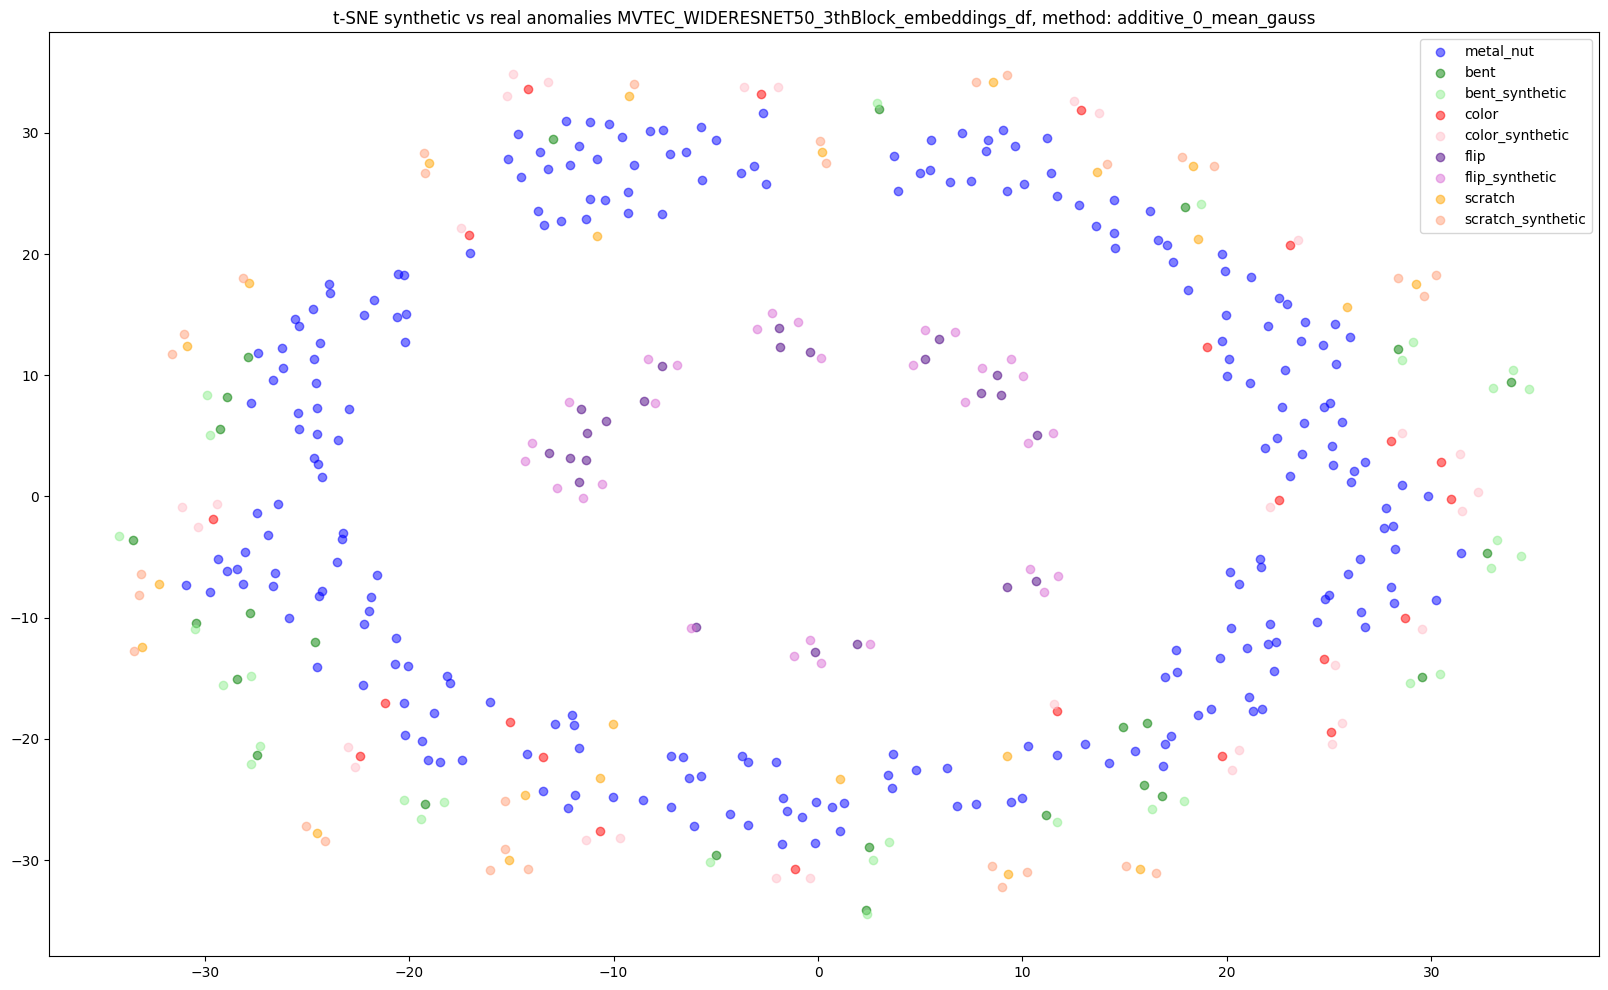

In [7]:
for _ in range(1):
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000)
    reduced_data = tsne.fit_transform(combined_samples)
    colors = ['blue', 'green', 'lightgreen', 'red', 'pink', 'indigo', 'orchid', 'orange', 'lightsalmon', 'purple', 'lavender', 'saddlebrown', 'wheat', 'black', 'gray','olive', 'palegreen']
    jitter_amount = 0.3
    # Plotting
    plt.figure(figsize=(20, 12))
    for i in range(len(class_list)):
        plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5, color=colors[i])
        
    plt.title(f"t-SNE synthetic vs real anomalies {FILENAME}, method: {info['sampler']}")
    plt.legend()
    plt.show()

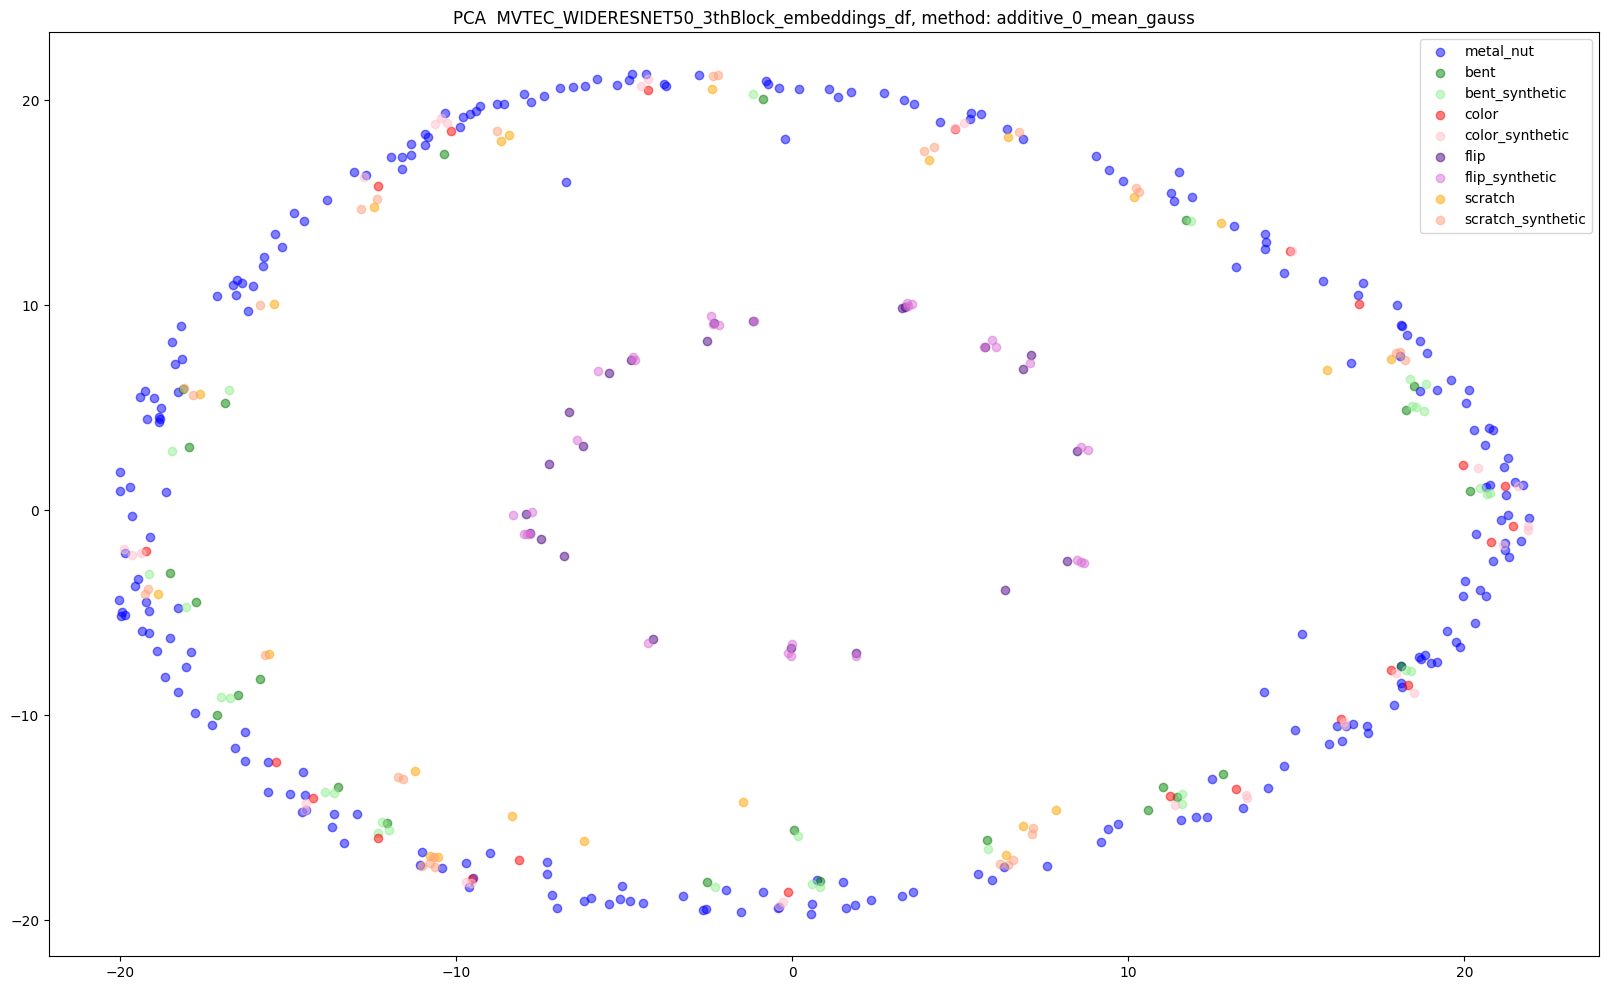

In [8]:
# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined_samples)

# Plotting
plt.figure(figsize=(20, 12))
# Iterate over each unique label to plot them separately
for i in range(len(class_list)):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5, color=colors[i])

plt.title(f"PCA  {FILENAME}, method: {info['sampler']}")
plt.legend()
plt.show()


# Model based Reconstruction

- learning normal state and detect deviation

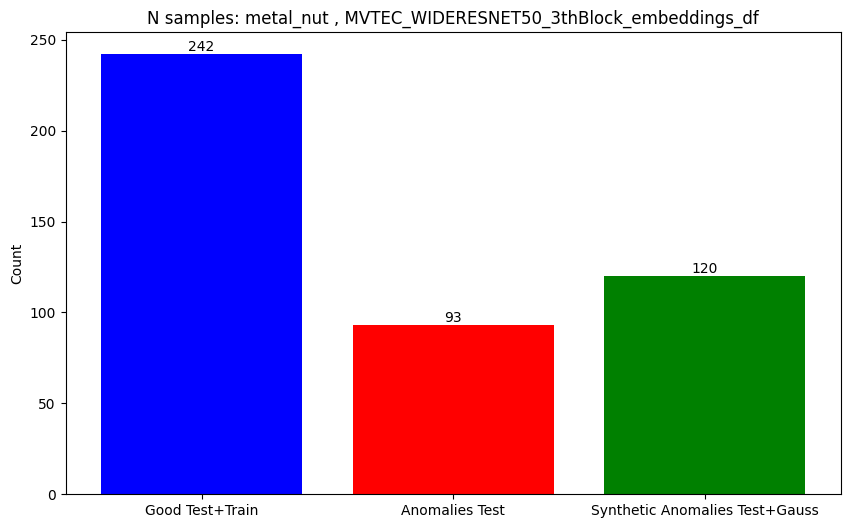

In [9]:
# filter for the synthetic and real anomalies
normals=combined_samples[labels==0]
anomalies=combined_samples[(labels % 2 != 0) & (labels != 0)] 
synthetic_anomalies=combined_samples[(labels % 2 == 0) & (labels != 0)] 
# plot it
plot_data_distribution(normals, anomalies, synthetic_anomalies,info=info)

## PCA

### "train" on normal data

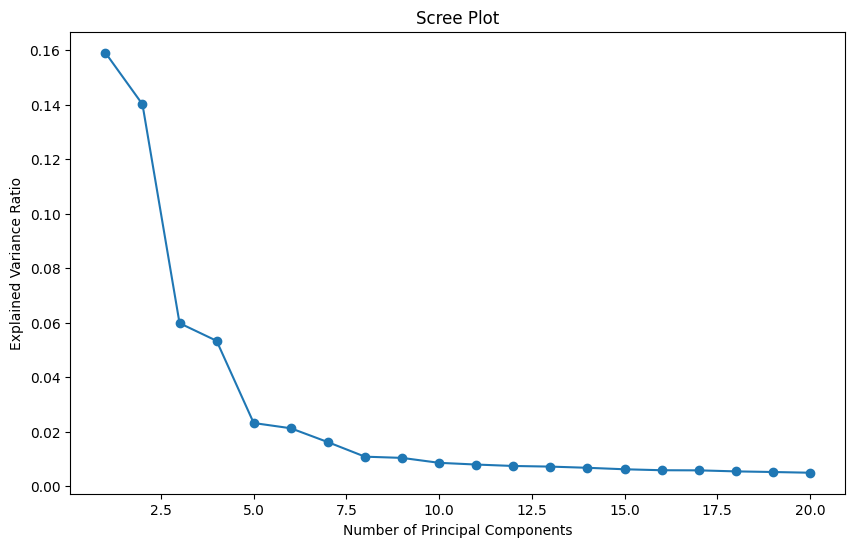

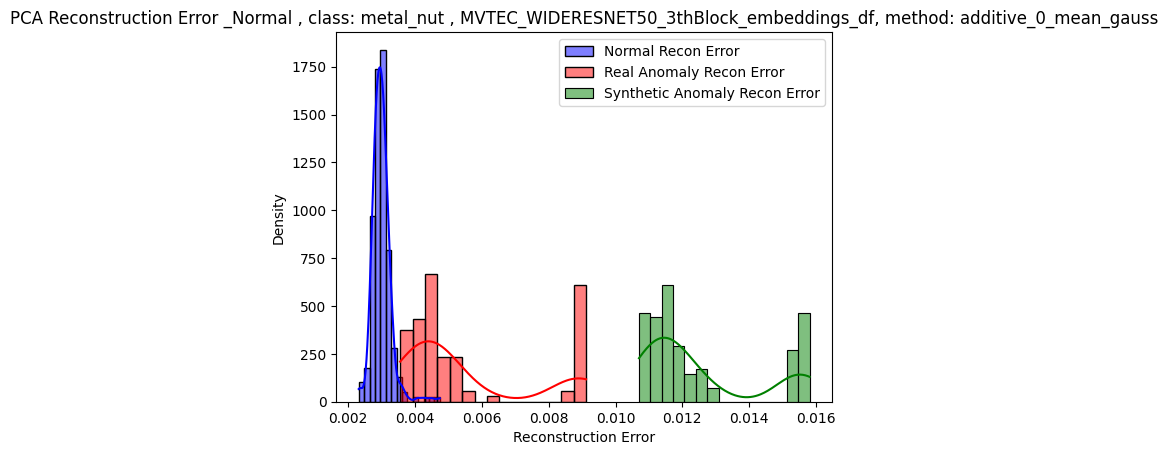

In [10]:
normal_data = np.array(normals)
anomalies = np.array(anomalies)
synthetic_anomalies = np.array(synthetic_anomalies)

n_dims=20
pca = PCA(n_components=n_dims)  # Reduce dimensionality

# empty recons 
normal_recon_error,anomaly_recon_error,synthetic_anomaly_recon_error = [],[],[]  #  empty recons

# Normal data
reduced_normal_data = pca.fit_transform(normal_data)  # Transform normal data
for i in range(len(reduced_normal_data)):
    reconstructed_normal = pca.inverse_transform(reduced_normal_data[i, :])
    normal_recon_error.append(mean_squared_error(normal_data[i], reconstructed_normal))
    
#Real Anomalies 
reduced_anomaly_data = pca.transform(anomalies)  
for i in range(len(reduced_anomaly_data)):
    reconstructed_anomaly = pca.inverse_transform(reduced_anomaly_data[i, :])
    anomaly_recon_error.append(mean_squared_error(anomalies[i], reconstructed_anomaly))

#Synthetic Anomalies 
reduced_synthetic_anomaly_data = pca.transform(synthetic_anomalies)
for i in range(len(reduced_synthetic_anomaly_data)):
    reconstructed_synthetic_anomaly = pca.inverse_transform(reduced_synthetic_anomaly_data[i, :])
    synthetic_anomaly_recon_error.append(mean_squared_error(synthetic_anomalies[i], reconstructed_synthetic_anomaly))

plt.figure(figsize=(10, 6))
bins_number = 15


plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o'),plt.title('Scree Plot'),plt.xlabel('Number of Principal Components'),plt.ylabel('Explained Variance Ratio'),plt.show()



# Plot distribution of reconstruction error
sns.histplot(normal_recon_error, label='Normal Recon Error', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_recon_error, label='Real Anomaly Recon Error', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_recon_error, label='Synthetic Anomaly Recon Error', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'PCA Reconstruction Error _Normal , class: {category} , {FILENAME}, method: {info["sampler"]}'),plt.xlabel('Reconstruction Error'),plt.ylabel('Density')
plt.legend()
plt.show()

### "train" on anomalous data

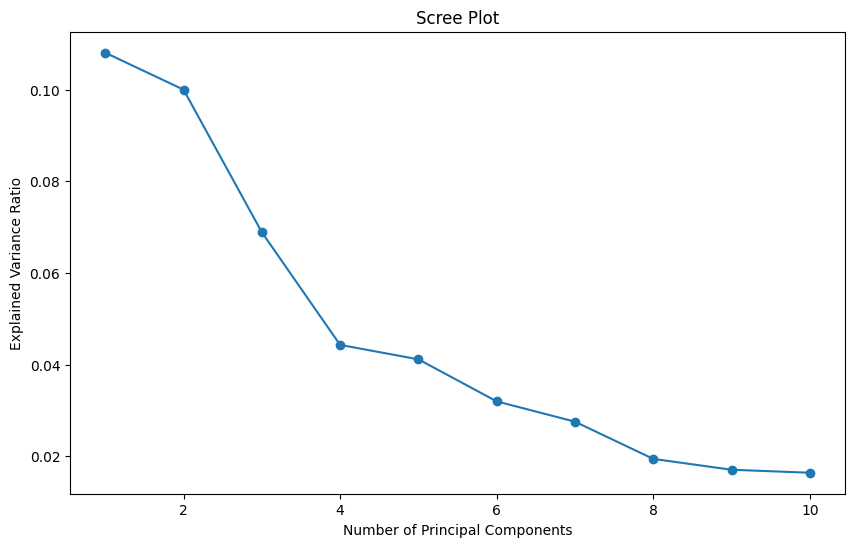

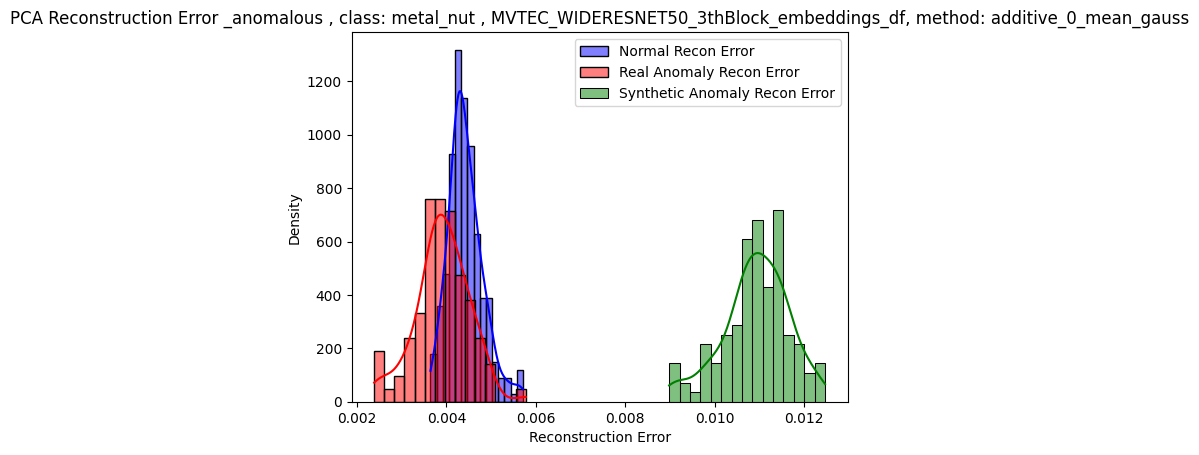

In [11]:
normal_data = np.array(normals)
anomalies = np.array(anomalies)
synthetic_anomalies = np.array(synthetic_anomalies)
n_dims=10
pca = PCA(n_components=n_dims)  # Reduce dimensionality

# empty recons 
normal_recon_error,anomaly_recon_error,synthetic_anomaly_recon_error = [],[],[]  #  empty recons

#Real Anomalies 
reduced_anomaly_data = pca.fit_transform(anomalies)  
for i in range(len(reduced_anomaly_data)):
    reconstructed_anomaly = pca.inverse_transform(reduced_anomaly_data[i, :])
    anomaly_recon_error.append(mean_squared_error(anomalies[i], reconstructed_anomaly))
    
# Normal data
reduced_normal_data = pca.transform(normal_data)  # Transform normal data
for i in range(len(reduced_normal_data)):
    reconstructed_normal = pca.inverse_transform(reduced_normal_data[i, :])
    normal_recon_error.append(mean_squared_error(normal_data[i], reconstructed_normal))
    
#Synthetic Anomalies 
reduced_synthetic_anomaly_data = pca.transform(synthetic_anomalies)
for i in range(len(reduced_synthetic_anomaly_data)):
    reconstructed_synthetic_anomaly = pca.inverse_transform(reduced_synthetic_anomaly_data[i, :])
    synthetic_anomaly_recon_error.append(mean_squared_error(synthetic_anomalies[i], reconstructed_synthetic_anomaly))

plt.figure(figsize=(10, 6))
bins_number = 15



plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o'),plt.title('Scree Plot'),plt.xlabel('Number of Principal Components'),plt.ylabel('Explained Variance Ratio'),plt.show()

# Plot distribution of reconstruction error
sns.histplot(normal_recon_error, label='Normal Recon Error', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_recon_error, label='Real Anomaly Recon Error', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_recon_error, label='Synthetic Anomaly Recon Error', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'PCA Reconstruction Error _anomalous , class: {category} , {FILENAME}, method: {info["sampler"]}'),plt.xlabel('Reconstruction Error'),plt.ylabel('Density')
plt.legend()
plt.show()

### "train" on synthethic anomalous data

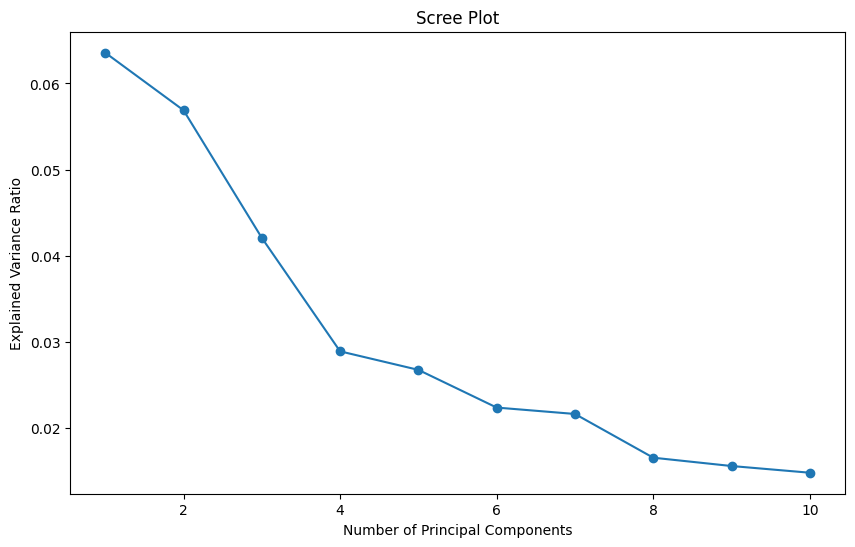

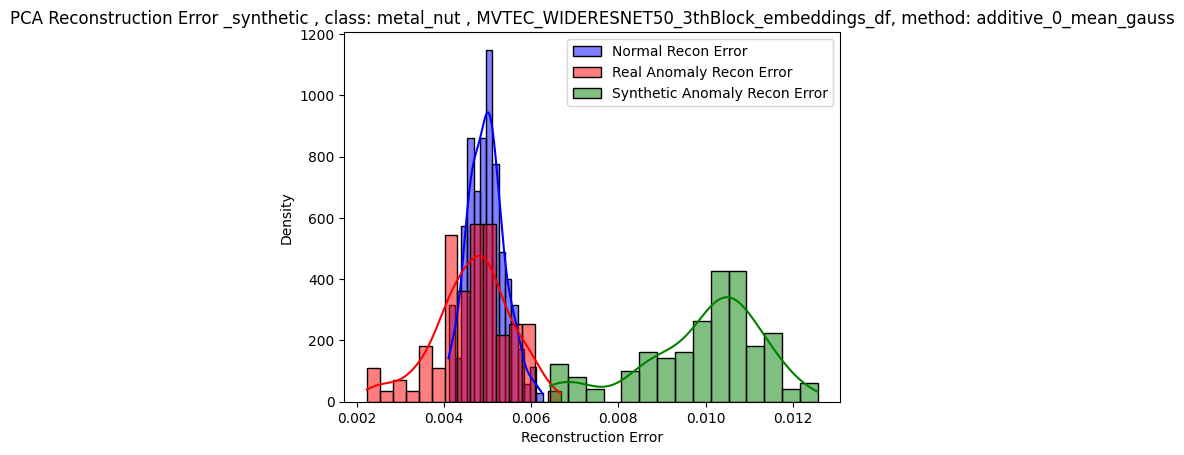

In [12]:
normal_data = np.array(normals)
anomalies = np.array(anomalies)
synthetic_anomalies = np.array(synthetic_anomalies)
n_dims=10
pca = PCA(n_components=n_dims)  # Reduce dimensionalit
# empty recons 
normal_recon_error,anomaly_recon_error,synthetic_anomaly_recon_error = [],[],[]  #  empty recons


#Synthetic Anomalies 
reduced_synthetic_anomaly_data = pca.fit_transform(synthetic_anomalies)
for i in range(len(reduced_synthetic_anomaly_data)):
    reconstructed_synthetic_anomaly = pca.inverse_transform(reduced_synthetic_anomaly_data[i, :])
    synthetic_anomaly_recon_error.append(mean_squared_error(synthetic_anomalies[i], reconstructed_synthetic_anomaly))
    
#Real Anomalies 
reduced_anomaly_data = pca.transform(anomalies)  
for i in range(len(reduced_anomaly_data)):
    reconstructed_anomaly = pca.inverse_transform(reduced_anomaly_data[i, :])
    anomaly_recon_error.append(mean_squared_error(anomalies[i], reconstructed_anomaly))
    
# Normal data
reduced_normal_data = pca.transform(normal_data)  # Transform normal data
for i in range(len(reduced_normal_data)):
    reconstructed_normal = pca.inverse_transform(reduced_normal_data[i, :])
    normal_recon_error.append(mean_squared_error(normal_data[i], reconstructed_normal))
    
plt.figure(figsize=(10, 6))
bins_number = 15


plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o'),plt.title('Scree Plot'),plt.xlabel('Number of Principal Components'),plt.ylabel('Explained Variance Ratio'),plt.show()


# Plot distribution of reconstruction error
sns.histplot(normal_recon_error, label='Normal Recon Error', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_recon_error, label='Real Anomaly Recon Error', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_recon_error, label='Synthetic Anomaly Recon Error', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'PCA Reconstruction Error _synthetic , class: {category} , {FILENAME}, method: {info["sampler"]}'),plt.xlabel('Reconstruction Error'),plt.ylabel('Density')
plt.legend()
plt.show()

## Autoencoder

- train autencoder to see wheter synthetic anomalies are valid or not

### train on normal data

Epoch [1/30], Train Loss: 172.2530, Validation Loss: 0.2445
Epoch [2/30], Train Loss: 0.0420, Validation Loss: 0.0214
Epoch [3/30], Train Loss: 0.0212, Validation Loss: 0.0207
Epoch [4/30], Train Loss: 0.0203, Validation Loss: 0.0198
Epoch [5/30], Train Loss: 0.0194, Validation Loss: 0.0189
Epoch [6/30], Train Loss: 0.0185, Validation Loss: 0.0180
Epoch [7/30], Train Loss: 0.0176, Validation Loss: 0.0171
Epoch [8/30], Train Loss: 0.0168, Validation Loss: 0.0163
Epoch [9/30], Train Loss: 0.0160, Validation Loss: 0.0155
Epoch [10/30], Train Loss: 0.0152, Validation Loss: 0.0148
Epoch [11/30], Train Loss: 0.0145, Validation Loss: 0.0142
Epoch [12/30], Train Loss: 0.0139, Validation Loss: 0.0135
Epoch [13/30], Train Loss: 0.0133, Validation Loss: 0.0129
Epoch [14/30], Train Loss: 0.0127, Validation Loss: 0.0124
Epoch [15/30], Train Loss: 0.0122, Validation Loss: 0.0119
Epoch [16/30], Train Loss: 0.0117, Validation Loss: 0.0114
Epoch [17/30], Train Loss: 0.0113, Validation Loss: 0.0110
Epoc

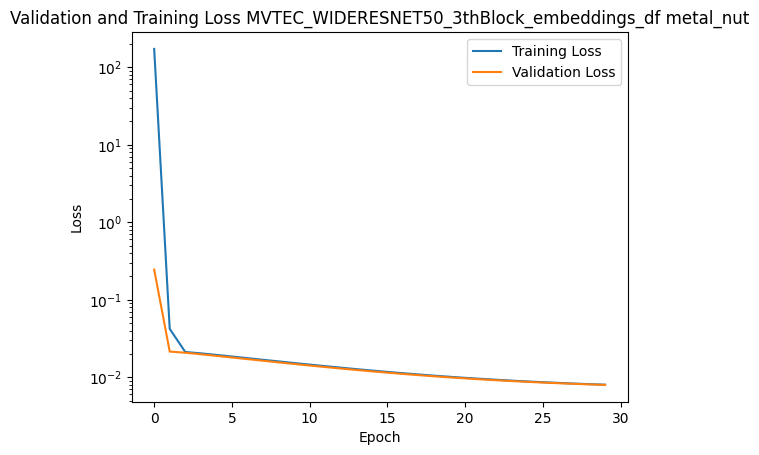

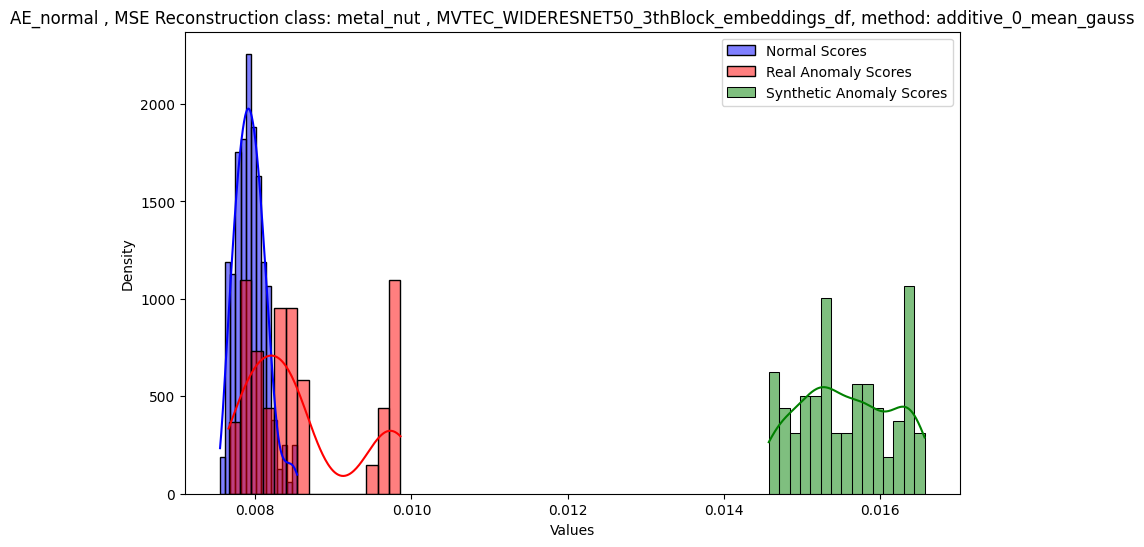

In [13]:
normal_data = torch.tensor(normals)
autoencoder_normal=train_autoencoder(normal_data, num_epochs=30,info=info)

normal_scores=np.mean((autoencoder_normal(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores, label='Real Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_normal , MSE Reconstruction class: {category} , {FILENAME}, method: {info["sampler"]}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

In [14]:
torch.cuda.empty_cache()
normal_data = torch.tensor(normals)

autoencoder_normal=train_autoencoder(normal_data, num_epochs=30,info=info)
normal_scores=np.mean((autoencoder_normal(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores, label='Real Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_normal , MSE Reconstruction class: {category} , {FILENAME}, method: {info["sampler"]}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

Epoch [1/30], Train Loss: 321.8278, Validation Loss: 0.0227
Epoch [2/30], Train Loss: 0.0232, Validation Loss: 0.0233
Epoch [3/30], Train Loss: 0.0231, Validation Loss: 0.0227
Epoch [4/30], Train Loss: 0.0223, Validation Loss: 0.0219
Epoch [5/30], Train Loss: 0.0215, Validation Loss: 0.0210
Epoch [6/30], Train Loss: 0.0207, Validation Loss: 0.0202
Epoch [7/30], Train Loss: 0.0199, Validation Loss: 0.0195
Epoch [8/30], Train Loss: 0.0191, Validation Loss: 0.0187
Epoch [9/30], Train Loss: 0.0184, Validation Loss: 0.0180
Epoch [10/30], Train Loss: 0.0176, Validation Loss: 0.0173
Epoch [11/30], Train Loss: 0.0169, Validation Loss: 0.0166
Epoch [12/30], Train Loss: 0.0163, Validation Loss: 0.0159
Epoch [13/30], Train Loss: 0.0157, Validation Loss: 0.0153
Epoch [14/30], Train Loss: 0.0151, Validation Loss: 0.0148
Epoch [15/30], Train Loss: 0.0145, Validation Loss: 0.0142
Epoch [16/30], Train Loss: 0.0140, Validation Loss: 0.0137
Epoch [17/30], Train Loss: 0.0135, Validation Loss: 0.0132
Epoc

KeyboardInterrupt: 

### Train on synthetic data

Epoch [1/30], Train Loss: 25.0832, Validation Loss: 0.2170
Epoch [2/30], Train Loss: 0.1304, Validation Loss: 0.0896
Epoch [3/30], Train Loss: 0.0611, Validation Loss: 0.0444
Epoch [4/30], Train Loss: 0.0325, Validation Loss: 0.0271
Epoch [5/30], Train Loss: 0.0235, Validation Loss: 0.0248
Epoch [6/30], Train Loss: 0.0224, Validation Loss: 0.0222
Epoch [7/30], Train Loss: 0.0211, Validation Loss: 0.0224
Epoch [8/30], Train Loss: 0.0212, Validation Loss: 0.0221
Epoch [9/30], Train Loss: 0.0212, Validation Loss: 0.0223
Epoch [10/30], Train Loss: 0.0213, Validation Loss: 0.0220
Epoch [11/30], Train Loss: 0.0213, Validation Loss: 0.0221
Epoch [12/30], Train Loss: 0.0212, Validation Loss: 0.0219
Epoch [13/30], Train Loss: 0.0213, Validation Loss: 0.0223
Epoch [14/30], Train Loss: 0.0212, Validation Loss: 0.0224
Epoch [15/30], Train Loss: 0.0215, Validation Loss: 0.0233
Epoch [16/30], Train Loss: 0.0214, Validation Loss: 0.0230
Epoch [17/30], Train Loss: 0.0210, Validation Loss: 0.0227
Early

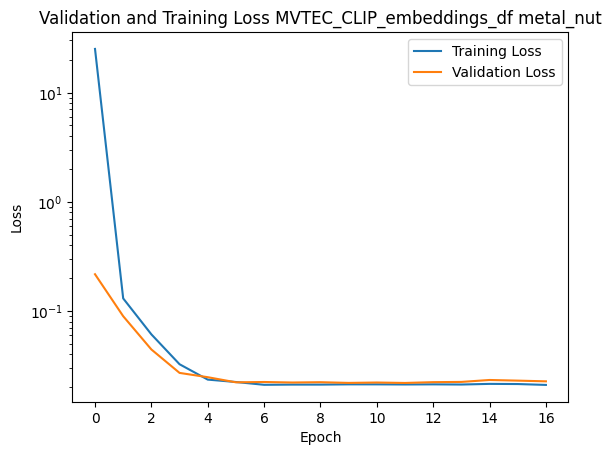

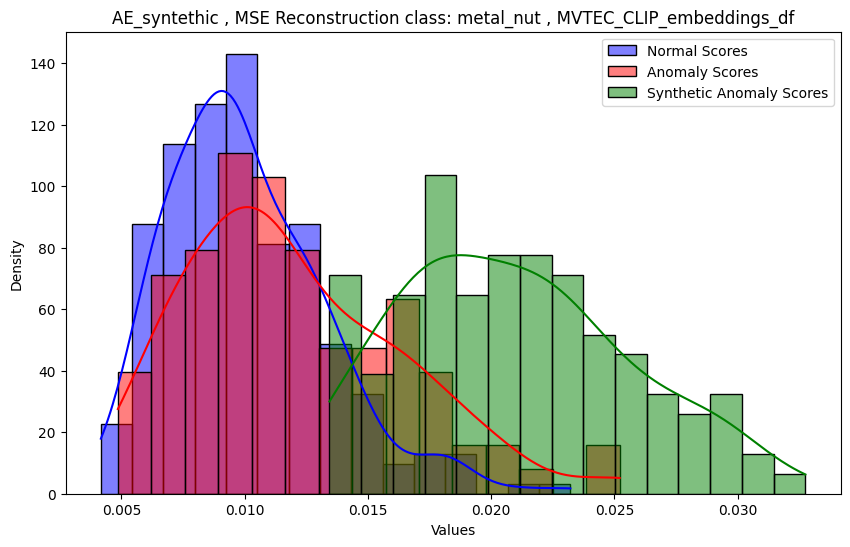

In [ ]:
torch.cuda.empty_cache()
synthethicdata = torch.tensor(synthetic_anomalies) #anomalies or synthetic_anomalies
autoencoder_synthetic=train_autoencoder(synthethicdata, num_epochs=30,info=info)

normal_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores_np, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores_np, label='Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores_np, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_syntethic , MSE Reconstruction class: {category} , {FILENAME}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

### Train on anomalies

Epoch [1/30], Train Loss: 39.4777, Validation Loss: 0.1311
Epoch [2/30], Train Loss: 0.0913, Validation Loss: 0.0537
Epoch [3/30], Train Loss: 0.0346, Validation Loss: 0.0180
Epoch [4/30], Train Loss: 0.0166, Validation Loss: 0.0162
Epoch [5/30], Train Loss: 0.0142, Validation Loss: 0.0144
Epoch [6/30], Train Loss: 0.0130, Validation Loss: 0.0132
Epoch [7/30], Train Loss: 0.0126, Validation Loss: 0.0124
Epoch [8/30], Train Loss: 0.0120, Validation Loss: 0.0129
Epoch [9/30], Train Loss: 0.0120, Validation Loss: 0.0129
Epoch [10/30], Train Loss: 0.0118, Validation Loss: 0.0120
Epoch [11/30], Train Loss: 0.0125, Validation Loss: 0.0122
Epoch [12/30], Train Loss: 0.0121, Validation Loss: 0.0125
Epoch [13/30], Train Loss: 0.0120, Validation Loss: 0.0120
Epoch [14/30], Train Loss: 0.0117, Validation Loss: 0.0124
Epoch [15/30], Train Loss: 0.0118, Validation Loss: 0.0126
Early stopping triggered!


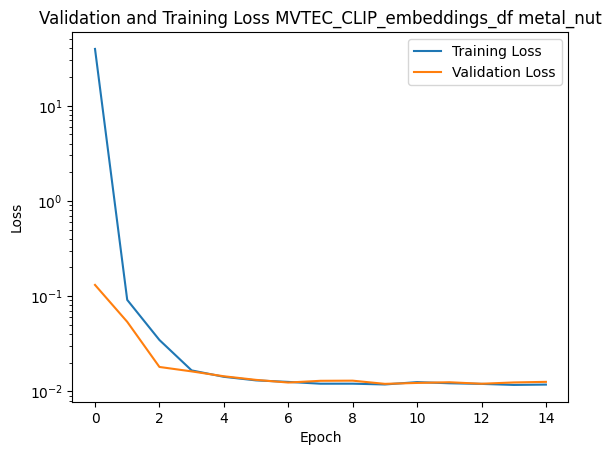

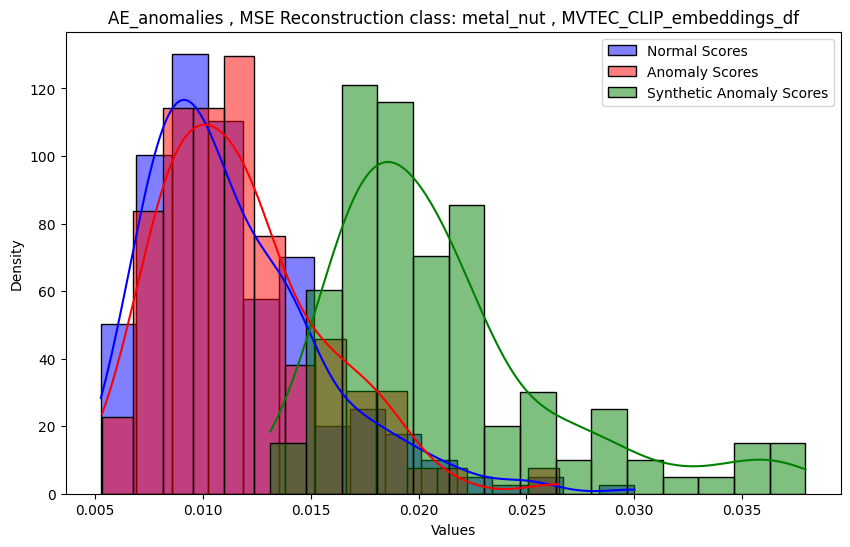

In [ ]:
torch.cuda.empty_cache()
anomaliesdata = torch.tensor(anomalies) #anomalies or synthetic_anomalies
autoencoder_synthetic=train_autoencoder(anomaliesdata, num_epochs=30,info=info)

normal_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores_np, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores_np, label='Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores_np, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_anomalies , MSE Reconstruction class: {category} , {FILENAME}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()